In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [50]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.metrics import classification_report_imbalanced
import matplotlib.pyplot as plt

# Read the CSV and Perform Basic Data Cleaning

In [51]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [52]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [53]:
df_binary_encoded =  pd.get_dummies(df, columns=['home_ownership','verification_status','pymnt_plan','initial_list_status','application_type'])
df_binary_encoded


,loan_amnt,int_rate,installment,annual_inc,issue_d,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,...,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App
0,10500.0,0.1719,375.35,66000.0,Mar-2019,low_risk,27.24,0.0,0.0,8.0,...,0,1,0,1,0,1,0,1,1,0
1,25000.0,0.2000,929.09,105000.0,Mar-2019,low_risk,20.23,0.0,0.0,17.0,...,0,0,0,0,1,1,0,1,1,0
2,20000.0,0.2000,529.88,56000.0,Mar-2019,low_risk,24.26,0.0,0.0,8.0,...,0,0,0,0,1,1,0,1,1,0
3,10000.0,0.1640,353.55,92000.0,Mar-2019,low_risk,31.44,0.0,1.0,10.0,...,0,1,0,0,1,1,0,1,1,0
4,22000.0,0.1474,520.39,52000.0,Mar-2019,low_risk,18.76,0.0,1.0,14.0,...,0,0,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,26000.0,Jan-2019,low_risk,9.60,0.0,0.0,9.0,...,0,1,0,1,0,1,0,1,1,0
68813,12000.0,0.2727,368.37,63000.0,Jan-2019,low_risk,29.07,0.0,0.0,8.0,...,0,1,1,0,0,1,0,1,1,0
68814,5000.0,0.1992,185.62,52000.0,Jan-2019,low_risk,14.86,0.0,0.0,5.0,...,0,0,0,1,0,1,0,1,1,0
68815,40000.0,0.0646,1225.24,520000.0,Jan-2019,low_risk,9.96,0.0,1.0,21.0,...,0,0,0,0,1,1,1,0,1,0


# Split the Data into Training and Testing

In [54]:
# Create our features
x_cols = [i for i in df_binary_encoded.columns if i not in ('loan_status')]
X = df_binary_encoded[x_cols]

# Create our target
y = df_binary_encoded[target]

In [55]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.106747,0.357659,0.478007,0.373992,0.148001,1.0,0.123879,0.876121,0.860340,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.308793,0.479314,0.499520,0.483865,0.355104,0.0,0.329446,0.329446,0.346637,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000


In [56]:
pd.set_option('display.max_rows', 500)
print(X.dtypes)


loan_amnt                              float64
int_rate                               float64
installment                            float64
annual_inc                             float64
issue_d                                 object
dti                                    float64
delinq_2yrs                            float64
inq_last_6mths                         float64
open_acc                               float64
pub_rec                                float64
revol_bal                              float64
total_acc                              float64
out_prncp                              float64
out_prncp_inv                          float64
total_pymnt                            float64
total_pymnt_inv                        float64
total_rec_prncp                        float64
total_rec_int                          float64
total_rec_late_fee                     float64
recoveries                             float64
collection_recovery_fee                float64
last_pymnt_am

In [57]:
df_binary_encoded =  pd.get_dummies(df, columns=['home_ownership','verification_status','pymnt_plan','initial_list_status','application_type'])
df_binary_encoded


,loan_amnt,int_rate,installment,annual_inc,issue_d,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,...,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App
0,10500.0,0.1719,375.35,66000.0,Mar-2019,low_risk,27.24,0.0,0.0,8.0,...,0,1,0,1,0,1,0,1,1,0
1,25000.0,0.2000,929.09,105000.0,Mar-2019,low_risk,20.23,0.0,0.0,17.0,...,0,0,0,0,1,1,0,1,1,0
2,20000.0,0.2000,529.88,56000.0,Mar-2019,low_risk,24.26,0.0,0.0,8.0,...,0,0,0,0,1,1,0,1,1,0
3,10000.0,0.1640,353.55,92000.0,Mar-2019,low_risk,31.44,0.0,1.0,10.0,...,0,1,0,0,1,1,0,1,1,0
4,22000.0,0.1474,520.39,52000.0,Mar-2019,low_risk,18.76,0.0,1.0,14.0,...,0,0,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,26000.0,Jan-2019,low_risk,9.60,0.0,0.0,9.0,...,0,1,0,1,0,1,0,1,1,0
68813,12000.0,0.2727,368.37,63000.0,Jan-2019,low_risk,29.07,0.0,0.0,8.0,...,0,1,1,0,0,1,0,1,1,0
68814,5000.0,0.1992,185.62,52000.0,Jan-2019,low_risk,14.86,0.0,0.0,5.0,...,0,0,0,1,0,1,0,1,1,0
68815,40000.0,0.0646,1225.24,520000.0,Jan-2019,low_risk,9.96,0.0,1.0,21.0,...,0,0,0,0,1,1,1,0,1,0


In [58]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [59]:
#pd.to_datetime(df_binary_encoded['issue_d'], format='%b-%y')
df_binary_encoded['issue_d'].value_counts()

Jan-2019    31041
Feb-2019    25579
Mar-2019    12197
Name: issue_d, dtype: int64

In [60]:
df_binary_encoded['next_pymnt_d'].value_counts()

May-2019    42449
Apr-2019    26368
Name: next_pymnt_d, dtype: int64

In [61]:
# Months dictionary 
# Small dictionary due to values in data. Would change to break out month and year if dataset encompassed a larger range.
months_num = {
    "Jan-2019": 1,
    "Feb-2019": 2,
    "Mar-2019": 3,
    "Apr-2019": 4,
    "May-2019": 5
}


In [62]:
df_binary_encoded["issued_month_num"] = df_binary_encoded["issue_d"].apply(lambda x: months_num[x])
df_binary_encoded['next_pymnt_month_num'] = df_binary_encoded["next_pymnt_d"].apply(lambda x: months_num[x])
df_binary_encoded[["issue_d", "next_pymnt_d","issued_month_num", 'next_pymnt_month_num']]

,issue_d,next_pymnt_d,issued_month_num,next_pymnt_month_num
0,Mar-2019,May-2019,3,5
1,Mar-2019,May-2019,3,5
2,Mar-2019,May-2019,3,5
3,Mar-2019,May-2019,3,5
4,Mar-2019,May-2019,3,5
...,...,...,...,...
68812,Jan-2019,May-2019,1,5
68813,Jan-2019,May-2019,1,5
68814,Jan-2019,May-2019,1,5
68815,Jan-2019,May-2019,1,5


In [63]:
df_binary_encoded[['hardship_flag','debt_settlement_flag']].value_counts()

hardship_flag  debt_settlement_flag
N              N                       68817
dtype: int64

In [64]:
# Can drop hardship_flag and debt_settlement_flag since all records have the same value

df_binary_encoded = df_binary_encoded.drop(["issue_d", "next_pymnt_d", "hardship_flag", "debt_settlement_flag"], axis=1)
df_binary_encoded


,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,issued_month_num,next_pymnt_month_num
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,...,0,1,0,1,0,1,1,0,3,5
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,...,0,0,1,1,0,1,1,0,3,5
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,...,0,0,1,1,0,1,1,0,3,5
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,...,0,0,1,1,0,1,1,0,3,5
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,...,1,0,0,1,0,1,1,0,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,26000.0,low_risk,9.60,0.0,0.0,9.0,0.0,...,0,1,0,1,0,1,1,0,1,5
68813,12000.0,0.2727,368.37,63000.0,low_risk,29.07,0.0,0.0,8.0,0.0,...,1,0,0,1,0,1,1,0,1,5
68814,5000.0,0.1992,185.62,52000.0,low_risk,14.86,0.0,0.0,5.0,1.0,...,0,1,0,1,0,1,1,0,1,5
68815,40000.0,0.0646,1225.24,520000.0,low_risk,9.96,0.0,1.0,21.0,0.0,...,0,0,1,1,1,0,1,0,1,5


In [65]:
x_cols = [i for i in df_binary_encoded.columns if i not in ('loan_status')]
X = df_binary_encoded[x_cols]

# Create our target
y = df_binary_encoded[target]

In [66]:
X.shape

(68817, 90)

In [67]:
y.shape

(68817, 1)

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [69]:
# !pip install imbalanced-learn --upgrade 

In [70]:
# !pip install scikit-learn --upgrade

In [71]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)


In [72]:
X_train.shape

(51612, 90)

In [73]:
y_train.shape

(51612, 1)

In [74]:
len(y_train)

51612

In [75]:
brf.fit(X = X_train,y= y_train)
y_pred = brf.predict(X_test)

In [76]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.7249311723735516

In [77]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[   59,    42],
       [ 2297, 14807]])

In [78]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.58      0.87      0.05      0.71      0.49       101
   low_risk       1.00      0.87      0.58      0.93      0.71      0.52     17104

avg / total       0.99      0.86      0.59      0.92      0.71      0.52     17205



In [79]:
# List the features sorted in descending order by feature importance
sorted(zip(brf.feature_importances_, X.columns), reverse=True)


[(0.07593900705995023, 'total_rec_prncp'),
 (0.06158702510225812, 'last_pymnt_amnt'),
 (0.05971837741050125, 'total_pymnt_inv'),
 (0.05636801158522087, 'total_rec_int'),
 (0.053249264619626695, 'total_pymnt'),
 (0.03246763953440453, 'issued_month_num'),
 (0.029691422170225613, 'int_rate'),
 (0.020259588682889063, 'dti'),
 (0.01846180356829768, 'installment'),
 (0.018297857274162107, 'out_prncp_inv'),
 (0.01676992851253479, 'mths_since_rcnt_il'),
 (0.016494904456867368, 'bc_util'),
 (0.016048256174651148, 'avg_cur_bal'),
 (0.015787124734893875, 'out_prncp'),
 (0.015757067082704634, 'mths_since_recent_inq'),
 (0.015347140677008743, 'mo_sin_old_rev_tl_op'),
 (0.015280191970815395, 'max_bal_bc'),
 (0.015137478536828525, 'total_rev_hi_lim'),
 (0.014524825259632885, 'annual_inc'),
 (0.014166710123839818, 'revol_bal'),
 (0.014045341826512276, 'total_il_high_credit_limit'),
 (0.013782183347963668, 'total_bal_ex_mort'),
 (0.013769077820743098, 'mo_sin_old_il_acct'),
 (0.013488979094652133, 'tot

### Easy Ensemble AdaBoost Classifier

In [80]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec.fit(X_train, y_train)
y_pred = eec.predict(X_test)

In [81]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.932069332400967

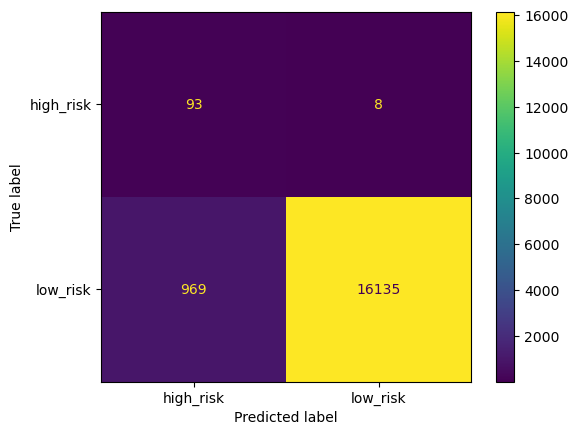

In [82]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = eec.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=eec.classes_)
# disp.figure_.savefig('EasyEnsemble.png', dpi=300) could not get to work - will manually save png
disp.plot()

In [83]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       101
   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205

